In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pylab as plt
import scipy
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [7]:
variables = ["code", "year", "gini_DS", "GDP_PWT", "GDP_PC_PWT", 
             "gov_consumption_WB", "years_schooling", "democracy_index", 
             "GDP_MP_WB", "GDP_growth_WB", "inflation_WB", "fertility_WB", 
             "dummy_africa", "dummy_south_america", "openness_WB"]
data = pd.read_csv("../data_source/all_data_barro.csv", usecols=variables)
data.set_index(['code', 'year'], inplace=True)
country_list = pd.read_csv("../data_source/country_code_list.csv", index_col='country')
data.head()

GDP_MP_WB  GDP_growth_WB  gov_consumption_WB  inflation_WB  \
code year                                                               
ABW  1960        NaN            NaN                 NaN           NaN   
     1961        NaN            NaN                 NaN           NaN   
     1962        NaN            NaN                 NaN           NaN   
     1963        NaN            NaN                 NaN           NaN   
     1964        NaN            NaN                 NaN           NaN   

           fertility_WB  gini_DS  GDP_PWT  GDP_PC_PWT  years_schooling  \
code year                                                                
ABW  1960         4.820      NaN      NaN         NaN              NaN   
     1961         4.655      NaN      NaN         NaN              NaN   
     1962         4.471      NaN      NaN         NaN              NaN   
     1963         4.271      NaN      NaN         NaN              NaN   
     1964         4.059      NaN      NaN         NaN              NaN   

           democracy_index  dummy_africa  dummy_south_america  openness_WB  
code year                                                                   
ABW  1960              NaN             0                    0          NaN  
     1961              NaN             0                    0          NaN  
     1962              NaN             0                    0          NaN  
     1963              NaN             0                    0          NaN  
     1964              NaN             0                    0          NaN

We only data keep posterior to 1960. We also remove the countries that do not appear in the list of countries. 

In [8]:
data = data.query('year >= 1955')
data = data.query("code in " + str(country_list['code'].values.tolist()))
data.dropna(how='all').info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12072 entries, (ABW, 1960.0) to (ZWE, 2014.0)
Data columns (total 13 columns):
GDP_MP_WB              8378 non-null float64
GDP_growth_WB          8397 non-null float64
gov_consumption_WB     7666 non-null float64
inflation_WB           6747 non-null float64
fertility_WB           10430 non-null float64
gini_DS                782 non-null float64
GDP_PWT                7974 non-null float64
GDP_PC_PWT             7974 non-null float64
years_schooling        1752 non-null float64
democracy_index        6630 non-null float64
dummy_africa           12072 non-null float64
dummy_south_america    12072 non-null float64
openness_WB            7991 non-null float64
dtypes: float64(13)
memory usage: 1.3+ MB


Here, we also make sure that is only one line of data for each couple year, country

# Resampling the data

Gather the rows by time periods and compute the mean on those periods

In [9]:
sample = data.reset_index(level=0).query("year < 1965").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [1960] * len(sample)
re_data = sample
sample = data.reset_index(level=0).query("1965 < year <= 1975").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [1970] * len(sample)
re_data = pd.concat([sample, re_data], axis=0)
sample = data.reset_index(level=0).query("1975 < year <= 1985").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [1980] * len(sample)
re_data = pd.concat([sample, re_data], axis=0)
sample = data.reset_index(level=0).query("1985 < year <= 1995").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [1990] * len(sample)
re_data = pd.concat([sample, re_data], axis=0)
sample = data.reset_index(level=0).query("1995 < year <= 2005").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [2000] * len(sample)
re_data = pd.concat([sample, re_data], axis=0)
sample = data.reset_index(level=0).query("2005 < year").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [2010] * len(sample)
re_data = pd.concat([sample, re_data], axis=0)
re_data = re_data.set_index(['code', 'year']).sort_index()
re_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1249 entries, (ABW, 1960) to (ZWE, 2010)
Data columns (total 13 columns):
GDP_MP_WB              944 non-null float64
GDP_growth_WB          959 non-null float64
gov_consumption_WB     886 non-null float64
inflation_WB           776 non-null float64
fertility_WB           1185 non-null float64
gini_DS                295 non-null float64
GDP_PWT                896 non-null float64
GDP_PC_PWT             896 non-null float64
years_schooling        876 non-null float64
democracy_index        791 non-null float64
dummy_africa           1243 non-null float64
dummy_south_america    1243 non-null float64
openness_WB            911 non-null float64
dtypes: float64(13)
memory usage: 136.6+ KB


# Ploting the data

The effect of resampling is OK

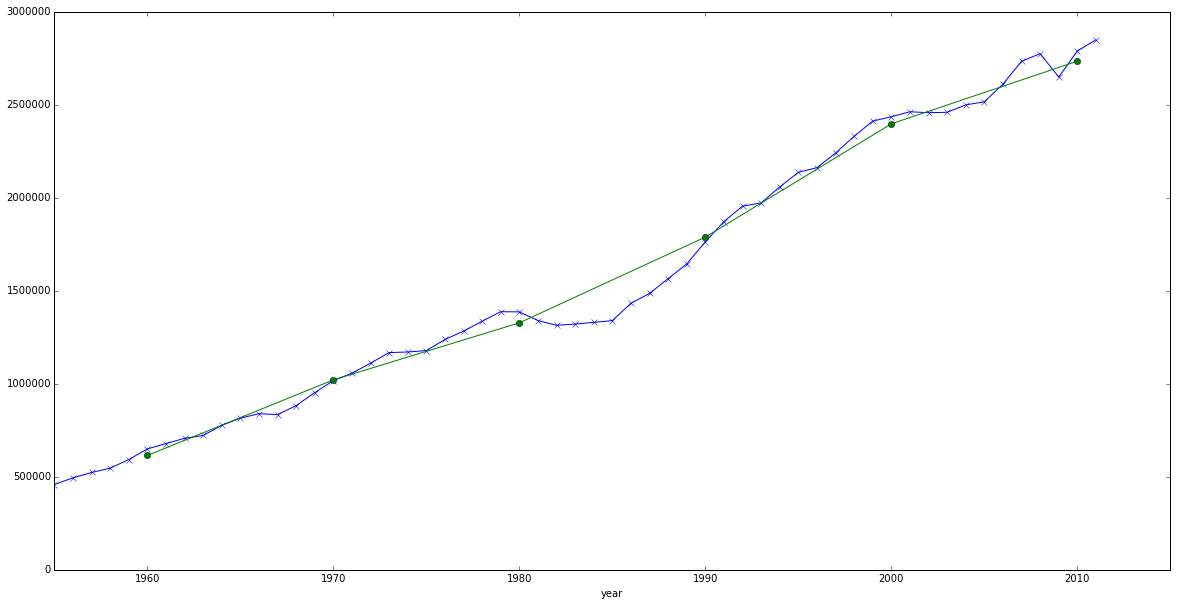

In [11]:
country = 'DEU'
plt.figure(figsize=(20,10))
data.loc['DEU']['GDP_PWT'].plot(marker='x')
re_data.loc['DEU']['GDP_PWT'].plot(marker='o')

<matplotlib.colorbar.Colorbar instance at 0x7fd857afbd40>

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


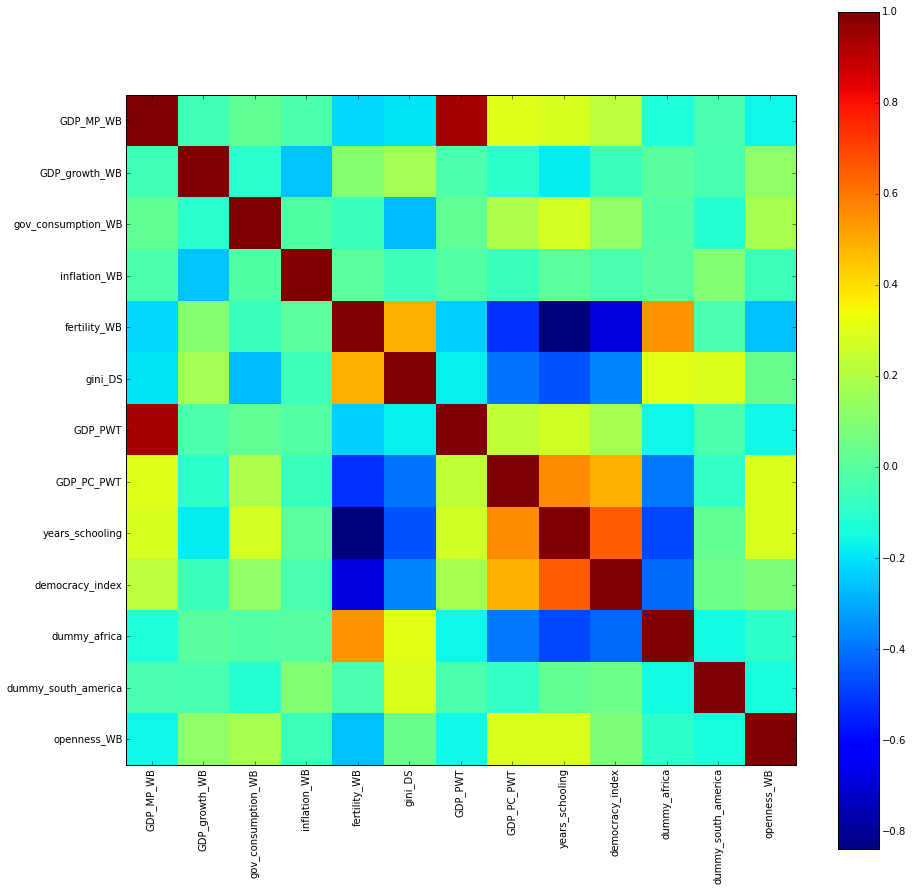

In [12]:
correlations = re_data.corr(min_periods=50)
fig = plt.figure(figsize=(15,15))
plt.imshow(correlations, interpolation='nearest')
plt.xticks(range(0, len(re_data.columns)), re_data.columns, rotation='vertical')
plt.yticks(range(0, len(re_data.columns)), re_data.columns, rotation='horizontal')
plt.colorbar()
# plt.savefig("graphs/correlations_variables.png")

# Regressions

## First regression without the gini coefficient

In [13]:
regression_data = re_data.loc[:, ["GDP_PC_PWT", "gov_consumption_WB", "democracy_index", 
                        "inflation_WB", "years_schooling", "fertility_WB", "GDP_growth_WB"]]
regression_data.loc[:, 'log(GDP)'] = regression_data['GDP_PC_PWT'].apply(np.log)
regression_data.loc[:, 'log(GDP)^2'] = regression_data['log(GDP)']**2
regression_data.loc[:, 'log(fertility)'] = regression_data['fertility_WB'].apply(np.log)
regression_data.loc[:, 'democracy_index^2'] = regression_data['democracy_index']**2
regression_data.dropna(how='any', inplace=True)
X = regression_data.loc[:, ["log(GDP)", 'log(GDP)^2', "gov_consumption_WB", "democracy_index", 
                     'democracy_index^2', "inflation_WB", "years_schooling", 'log(fertility)']]
Y = regression_data.loc[:, "GDP_growth_WB"]

In [14]:
X_sm = sm.add_constant(X)
model = sm.OLS(Y, X_sm)
all_results = model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:          GDP_growth_WB   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     12.32
Date:                Tue, 01 Mar 2016   Prob (F-statistic):           6.87e-16
Time:                        09:02:42   Log-Likelihood:                -1035.0
No. Observations:                 431   AIC:                             2088.
Df Residuals:                     422   BIC:                             2125.
Df Model:                           8                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                -10.0163      7.404     -1.353      0.177       -24.570     4.537
log(GDP)               3.620

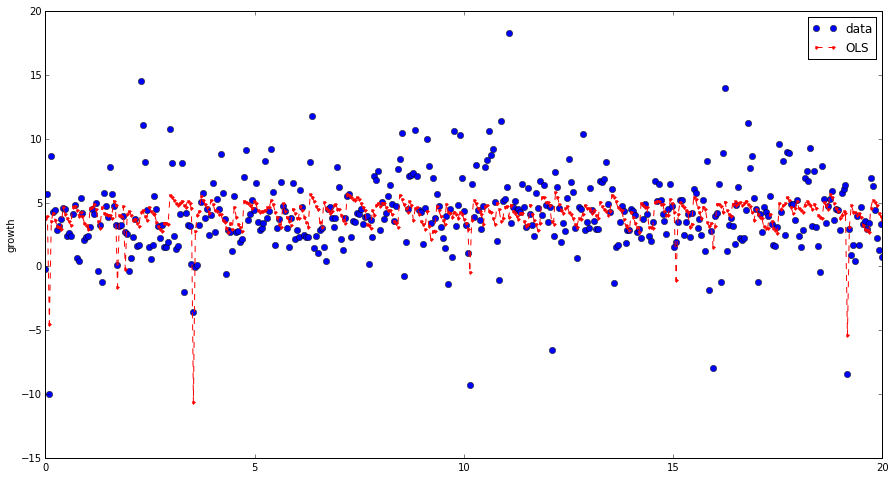

In [15]:
prstd, iv_l, iv_u = wls_prediction_std(all_results)
x = np.linspace(0, 20, len(X))
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(x, Y, 'o', label="data")
ax.plot(x, all_results.fittedvalues, 'r--.', label="OLS")
plt.ylabel("growth")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

### Three stages least-squares

In [16]:
coef_se = pd.concat([all_results.params, all_results.bse], axis=1, keys=["coef", "SE"])
coef_se.loc["R^2", "coef"] = all_results.rsquared
coef_se.loc["Nbr obse", "coef"] = all_results.nobs
all_coefs = {"all": coef_se}
for year in ['1960', '1970', '1980', '1990', '2000']:
    X_i = X.query("year == " + str(year))
    Y_i = pd.DataFrame(Y).query("year == " + str(year))
    X_sm = sm.add_constant(X_i)
    model = sm.OLS(Y_i, X_sm)
    results = model.fit()
    coef_se = pd.concat([results.params, results.bse], axis=1, keys=["coef", "SE"])
    coef_se.loc["R^2", "coef"] = results.rsquared
    coef_se.loc["Nbr obse", "coef"] = results.nobs
    all_coefs[year] = coef_se
all_coef = pd.concat([all_coefs[y] for y in np.sort(all_coefs.keys())], axis=1, keys=[y for y in np.sort(all_coefs.keys())])
all_coef

1960                  1970                  1980  \
                         coef         SE       coef         SE       coef   
const              -40.019361  32.980276 -44.967785  24.493447  -5.824937   
log(GDP)            12.631942   8.001478  11.333398   5.902526   3.753501   
log(GDP)^2          -0.803887   0.493042  -0.651227   0.355649  -0.268423   
gov_consumption_WB  -0.061802   0.119641   0.163474   0.084865   0.073688   
democracy_index     -0.219400   0.101860  -0.006453   0.126273  -0.102163   
democracy_index^2    0.004481   0.002789  -0.001994   0.003291   0.000538   
inflation_WB        -0.044285   0.021141   0.007777   0.018661  -0.003109   
years_schooling      0.349461   0.232418  -0.032648   0.288836   0.058167   
log(fertility)      -1.244583   1.156383   0.298607   1.550908  -2.316303   
R^2                  0.310877        NaN   0.169097        NaN   0.141448   
Nbr obse            47.000000        NaN  69.000000        NaN  84.000000   

                                     1990                   2000             \
                           SE        coef         SE        coef         SE   
const               18.128998  -10.532554  17.244724   31.301309  11.340932   
log(GDP)             4.154756    2.256692   4.097762   -5.234395   2.533867   
log(GDP)^2           0.238336   -0.054697   0.243236    0.270991   0.143149   
gov_consumption_WB   0.058518   -0.071693   0.062756   -0.075551   0.047243   
democracy_index      0.098333    0.034404   0.108371   -0.061634   0.066213   
democracy_index^2    0.002433   -0.000093   0.002463    0.000267   0.001628   
inflation_WB         0.001923   -0.003672   0.000686   -0.026071   0.010170   
years_schooling      0.211959   -0.439812   0.217453    0.111699   0.147287   
log(fertility)       1.452783    1.954929   1.329119   -1.033455   0.826204   
R^2                       NaN    0.337715        NaN    0.153415        NaN   
Nbr obse                  NaN  111.000000        NaN  120.000000        NaN   

                           all            
                          coef        SE  
const               -10.016302  7.404072  
log(GDP)              3.620559  1.738587  
log(GDP)^2           -0.202277  0.102438  
gov_consumption_WB   -0.039462  0.028630  
democracy_index      -0.008883  0.043785  
democracy_index^2     0.000137  0.001101  
inflation_WB         -0.004498  0.000567  
years_schooling      -0.186700  0.090821  
log(fertility)        0.197774  0.536711  
R^2                   0.189275       NaN  
Nbr obse            431.000000       NaN

## Scatter plots growth vs Gini

In [17]:
reg_data_gini = re_data.loc[:, ["GDP_PC_PWT", "gov_consumption_WB", "democracy_index", 
                        "inflation_WB", "years_schooling", "fertility_WB", "GDP_growth_WB", "gini_DS"]]
reg_data_gini.loc[:, 'log(GDP)'] = reg_data_gini['GDP_PC_PWT'].apply(np.log)
reg_data_gini.loc[:, 'log(GDP)^2'] = reg_data_gini['log(GDP)']**2
reg_data_gini.loc[:, 'log(fertility)'] = reg_data_gini['fertility_WB'].apply(np.log)
reg_data_gini.loc[:, 'democracy_index^2'] = reg_data_gini['democracy_index']**2
reg_data_gini.dropna(how='any', inplace=True)
X_gini = reg_data_gini.loc[:, ["log(GDP)", 'log(GDP)^2', "gov_consumption_WB", "democracy_index", 
                     'democracy_index^2', "inflation_WB", "years_schooling", 'log(fertility)', 'gini_DS']]
Y_gini = reg_data_gini.loc[:, "GDP_growth_WB"]

First we plot the growth w.t.r to the gini coefficient

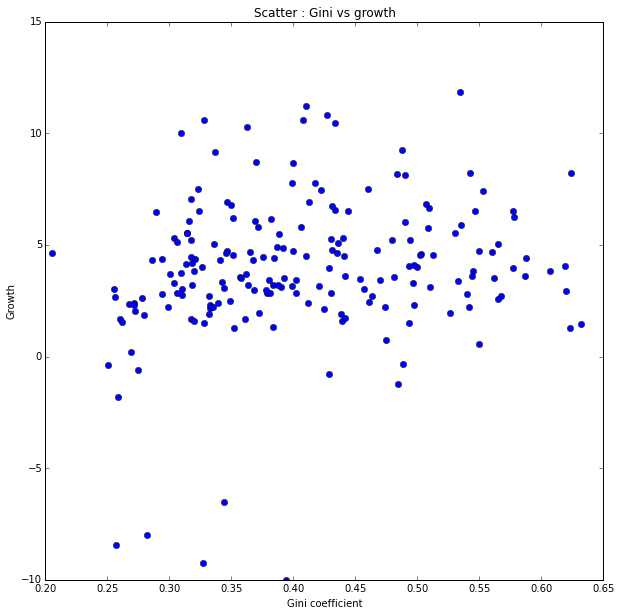

In [18]:
plt.figure(figsize=(10,10))
plt.plot(X_gini["gini_DS"], Y_gini, 'o')
plt.xlabel("Gini coefficient")
plt.ylabel("Growth")
plt.title("Scatter : Gini vs growth")

Then, we plot the unexplained part of the growth w.t.r to the gini coefficient

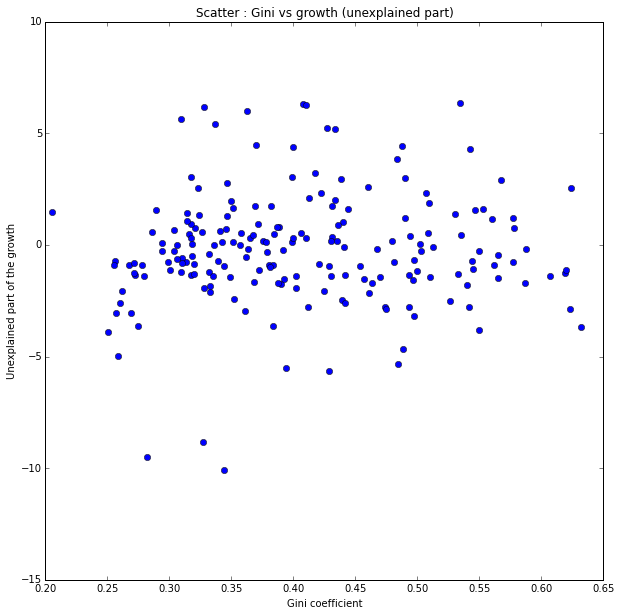

In [19]:
unexplained = [Y.loc[point] - np.dot(all_results.params, np.insert(X.loc[point].values, 0, 1))
               for point in X_gini.index]
plt.figure(figsize=(10,10))
plt.plot(X_gini["gini_DS"], unexplained, 'o')
plt.xlabel("Gini coefficient")
plt.ylabel("Unexplained part of the growth")
plt.title("Scatter : Gini vs growth (unexplained part)")

Then the unexplained part of growth w.r.t gini for low and high values of the GDP

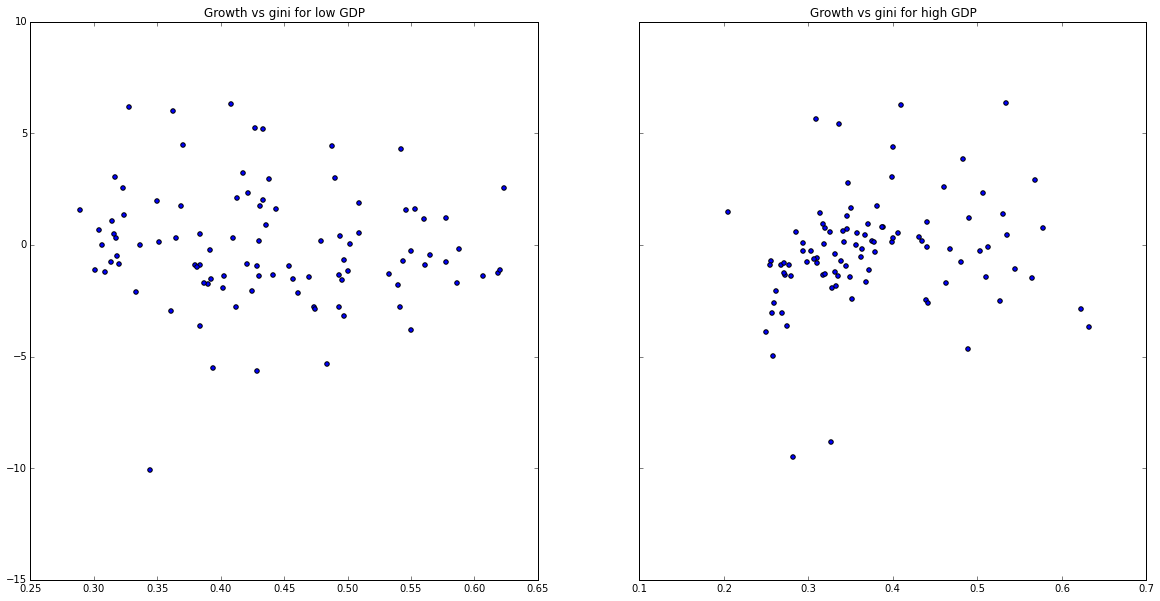

In [20]:
med_GDP = X_gini['log(GDP)'].median()
high_unexplained = [Y.loc[point] - np.dot(all_results.params, np.insert(X.loc[point].values, 0, 1))
                    for point in X_gini[X_gini['log(GDP)'] > med_GDP].index]
low_unexplained = [Y.loc[point] - np.dot(all_results.params, np.insert(X.loc[point].values, 0, 1))
                    for point in X_gini[X_gini['log(GDP)'] < med_GDP].index]
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), sharey=True)
ax1.scatter(X_gini[X_gini['log(GDP)'] < med_GDP]['gini_DS'], low_unexplained)
ax1.set_title("Growth vs gini for low GDP")
ax2.scatter(X_gini[X_gini['log(GDP)'] > med_GDP]['gini_DS'], high_unexplained)
ax2.set_title("Growth vs gini for high GDP")

## Regressions with the gini coef

In [21]:
X_sm = sm.add_constant(X_gini)
model_gini = sm.OLS(Y_gini, X_sm)
all_results_gini = model_gini.fit()
print(all_results_gini.summary())

                            OLS Regression Results                            
Dep. Variable:          GDP_growth_WB   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     14.50
Date:                Tue, 01 Mar 2016   Prob (F-statistic):           1.31e-17
Time:                        09:03:10   Log-Likelihood:                -445.90
No. Observations:                 194   AIC:                             911.8
Df Residuals:                     184   BIC:                             944.5
Df Model:                           9                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                -38.2122     14.053     -2.719      0.007       -65.938   -10.486
log(GDP)              10.469

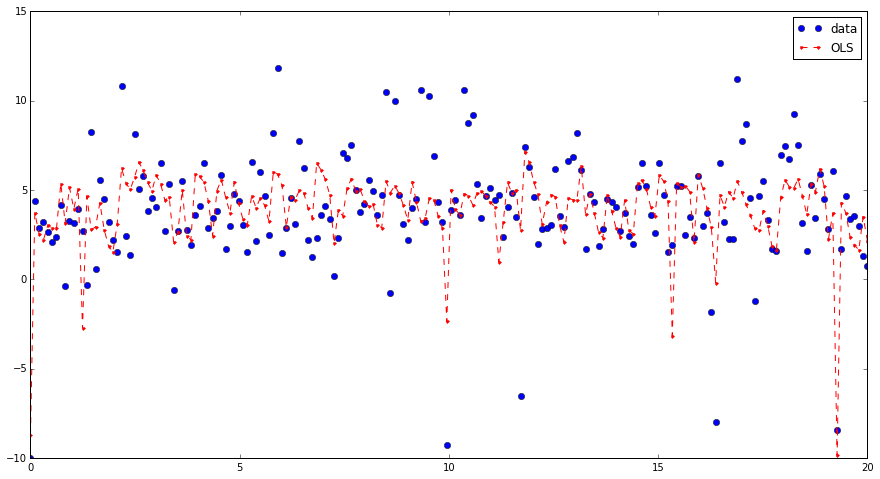

In [22]:
prstd, iv_l, iv_u = wls_prediction_std(all_results_gini)
x = np.linspace(0, 20, len(X_gini))
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(x, Y_gini, 'o', label="data")
ax.plot(x, all_results_gini.fittedvalues, 'r--.', label="OLS")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

### Three stage least squares

In [23]:
coef_se = pd.concat([all_results_gini.params, all_results_gini.bse], axis=1, keys=["coef", "SE"])
coef_se.loc["R^2", "coef"] = all_results_gini.rsquared
coef_se.loc["Nbr obse", "coef"] = all_results_gini.nobs
all_coefs = {"all": coef_se}
for year in ['1960', '1970', '1980', '1990']:
    X_i = X_gini.query("year == " + str(year))
    Y_i = pd.DataFrame(Y_gini).query("year == " + str(year))
    X_sm = sm.add_constant(X_i)
    model = sm.OLS(Y_i, X_sm)
    results = model.fit()
    coef_se = pd.concat([results.params, results.bse], axis=1, keys=["coef", "SE"])
    coef_se.loc["R^2", "coef"] = results.rsquared
    coef_se.loc["Nbr obse", "coef"] = results.nobs
    all_coefs[year] = coef_se
all_coef = pd.concat([all_coefs[y] for y in np.sort(all_coefs.keys())], axis=1, keys=[y for y in np.sort(all_coefs.keys())])
all_coef

1960                  1970                  1980  \
                         coef         SE       coef         SE       coef   
const              -77.506177  53.121667 -81.726978  36.942672 -35.955577   
log(GDP)            23.639563  13.142879  22.509312   9.148358  12.265404   
log(GDP)^2          -1.449951   0.806837  -1.334073   0.564556  -0.759905   
gov_consumption_WB  -0.187017   0.201015  -0.068139   0.116154   0.049644   
democracy_index     -0.305099   0.150186  -0.131553   0.116943  -0.249467   
democracy_index^2    0.005741   0.003773   0.002067   0.003229   0.002519   
inflation_WB        -0.036996   0.023463  -0.000630   0.016257  -0.011822   
years_schooling      0.263157   0.326557  -0.079867   0.265059   0.053754   
log(fertility)      -2.815799   1.548688  -0.504192   2.186376  -2.689258   
gini_DS             -8.005821   5.617536  -8.370785   6.376239  -9.224410   
R^2                  0.546553        NaN   0.292406        NaN   0.377552   
Nbr obse            26.000000        NaN  41.000000        NaN  52.000000   

                                    1990                    all             
                           SE       coef         SE        coef         SE  
const               22.982784 -17.591333  23.971191  -38.212186  14.053188  
log(GDP)             5.633737   4.459448   5.605560   10.469005   3.439304  
log(GDP)^2           0.338818  -0.229324   0.334668   -0.589975   0.209219  
gov_consumption_WB   0.080085  -0.174838   0.074279   -0.145474   0.045785  
democracy_index      0.099120   0.083565   0.118011   -0.031992   0.059873  
democracy_index^2    0.002445  -0.000392   0.002726    0.001113   0.001510  
inflation_WB         0.014384  -0.005898   0.000933   -0.006632   0.000811  
years_schooling      0.210169  -0.262789   0.229436   -0.216447   0.126688  
log(fertility)       1.584666   1.084992   1.673588    0.696599   0.855311  
gini_DS              4.536194   5.227554   4.004681   -1.515889   2.444500  
R^2                       NaN   0.529750        NaN    0.414868        NaN  
Nbr obse                  NaN  75.000000        NaN  194.000000        NaN

### Regression with Gini and without the fertility

In [24]:
cols_list = X_gini.keys().tolist()
cols_list.remove("log(fertility)")
X_sm = sm.add_constant(X_gini[cols_list])
model_gini = sm.OLS(Y_gini, X_sm)
all_results_gini = model_gini.fit()
print(all_results_gini.summary())

                            OLS Regression Results                            
Dep. Variable:          GDP_growth_WB   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     16.25
Date:                Tue, 01 Mar 2016   Prob (F-statistic):           4.27e-18
Time:                        09:03:57   Log-Likelihood:                -446.25
No. Observations:                 194   AIC:                             910.5
Df Residuals:                     185   BIC:                             939.9
Df Model:                           8                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                -36.8495     13.941     -2.643      0.009       -64.352    -9.347
log(GDP)              10.504

# Kuznets curve

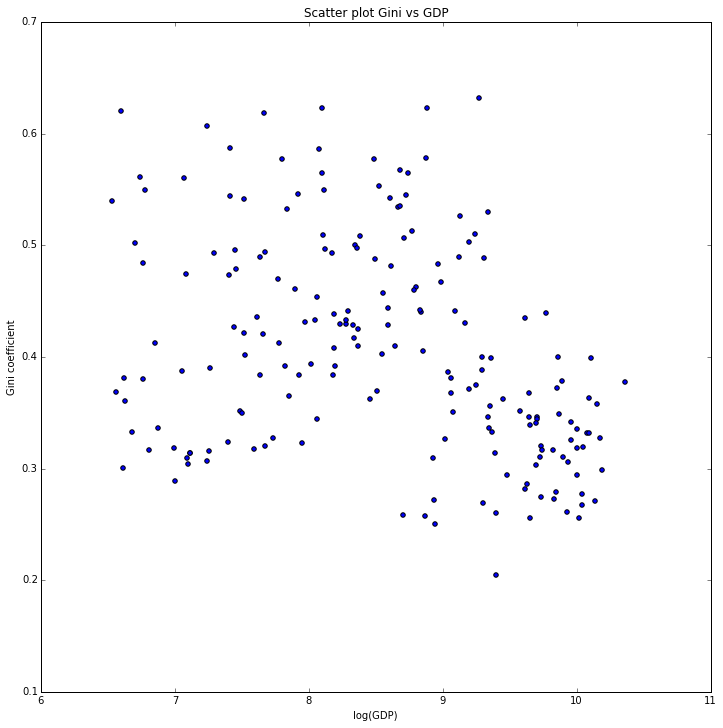

In [25]:
plt.figure(figsize=(12,12))
plt.scatter(X_gini['log(GDP)'], X_gini['gini_DS'])
plt.xlabel("log(GDP)")
plt.ylabel("Gini coefficient")
plt.title("Scatter plot Gini vs GDP")

# Determinants of inequality (regression on the Gini coefficient)

In [26]:
reg_data_gini = re_data.loc[:, ["GDP_PC_PWT", "years_schooling", "dummy_africa", "dummy_south_america", 
                                "democracy_index", "openness_WB", "gini_DS"]]
reg_data_gini.loc[:, 'log(GDP)'] = reg_data_gini['GDP_PC_PWT'].apply(np.log)
reg_data_gini.loc[:, 'log(GDP)^2'] = reg_data_gini['log(GDP)']**2
reg_data_gini.loc[:, 'openness*log(GDP)'] = reg_data_gini['openness_WB'] * reg_data_gini['log(GDP)']
reg_data_gini.dropna(how='any', inplace=True)
X_ineq = reg_data_gini.loc[:, ["log(GDP)", 'log(GDP)^2', "years_schooling", "dummy_africa", 
                               "dummy_south_america", "democracy_index", "openness_WB",  'openness*log(GDP)']]
Y_ineq = reg_data_gini.loc[:, "gini_DS"]

In [27]:
X_sm = sm.add_constant(X_ineq)
model_gini = sm.OLS(Y_ineq, X_sm)
ineq_results = model_gini.fit()
print(ineq_results.summary())

                            OLS Regression Results                            
Dep. Variable:                gini_DS   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     24.33
Date:                Tue, 01 Mar 2016   Prob (F-statistic):           7.83e-27
Time:                        09:04:05   Log-Likelihood:                 284.64
No. Observations:                 236   AIC:                            -551.3
Df Residuals:                     227   BIC:                            -520.1
Df Model:                           8                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
const                  -0.8552      0.387     -2.209      0.028        -1.618    -0.092
log(GDP)                0

### Three stage least squares

In [28]:
coef_se = pd.concat([ineq_results.params, ineq_results.bse], axis=1, keys=["coef", "SE"])
coef_se.loc["R^2", "coef"] = ineq_results.rsquared
coef_se.loc["Nbr obse", "coef"] = ineq_results.nobs
all_coefs = {"all": coef_se}
for year in ['1960', '1970', '1980', '1990']:
    X_i = X_ineq.query("year == " + str(year))
    Y_i = pd.DataFrame(Y_ineq).query("year == " + str(year))
    X_sm = sm.add_constant(X_i)
    model = sm.OLS(Y_i, X_sm)
    results = model.fit()
    coef_se = pd.concat([results.params, results.bse], axis=1, keys=["coef", "SE"])
    coef_se.loc["R^2", "coef"] = results.rsquared
    coef_se.loc["Nbr obse", "coef"] = results.nobs
    all_coefs[year] = coef_se
all_coef = pd.concat([all_coefs[y] for y in np.sort(all_coefs.keys())], axis=1, keys=[y for y in np.sort(all_coefs.keys())])
all_coef

1960                 1970                 1980  \
                          coef        SE       coef        SE       coef   
const                -3.931877  1.355787  -1.983123  1.045413  -0.292764   
log(GDP)              1.047806  0.340131   0.531158  0.256921   0.104143   
log(GDP)^2           -0.060871  0.021141  -0.027798  0.015873  -0.002424   
years_schooling      -0.018149  0.010332  -0.017384  0.007194  -0.007256   
dummy_africa         -0.028393  0.045354   0.006616  0.034346   0.042288   
dummy_south_america   0.029801  0.042615   0.067598  0.030533   0.122074   
democracy_index      -0.002049  0.002404  -0.001080  0.001446  -0.002271   
openness_WB           0.427295  0.644061   0.932182  0.410802   0.903105   
openness*log(GDP)    -0.044113  0.075753  -0.106883  0.047911  -0.095894   
R^2                   0.551838       NaN   0.517800       NaN   0.546472   
Nbr obse             36.000000       NaN  54.000000       NaN  60.000000   

                                    1990                   all            
                           SE       coef        SE        coef        SE  
const                0.770356  -0.216040  0.662482   -0.855221  0.387183  
log(GDP)             0.193281   0.105608  0.160019    0.265119  0.095512  
log(GDP)^2           0.012128  -0.003292  0.009732   -0.012759  0.005910  
years_schooling      0.006632  -0.012780  0.006158   -0.013462  0.002923  
dummy_africa         0.029886   0.048511  0.030152    0.033545  0.015768  
dummy_south_america  0.036484   0.129334  0.035255    0.097606  0.017158  
democracy_index      0.001151  -0.001709  0.001364   -0.001558  0.000677  
openness_WB          0.327724   0.572800  0.229537    0.589844  0.139643  
openness*log(GDP)    0.035223  -0.058811  0.024565   -0.062578  0.015247  
R^2                       NaN   0.425181       NaN    0.461628       NaN  
Nbr obse                  NaN  85.000000       NaN  236.000000       NaN

# Using normalized data

In [36]:
regression_data_norm = re_data.loc[:, ["GDP_PC_PWT", "gov_consumption_WB", "democracy_index", 
                        "inflation_WB", "years_schooling", "fertility_WB", "GDP_growth_WB", 'gini_DS']]
regression_data_norm.loc[:, 'log(GDP)'] = regression_data['GDP_PC_PWT'].apply(np.log)
regression_data_norm.loc[:, 'log(GDP)^2'] = regression_data['log(GDP)']**2
regression_data_norm.loc[:, 'log(fertility)'] = regression_data['fertility_WB'].apply(np.log)
regression_data_norm.loc[:, 'democracy_index^2'] = regression_data['democracy_index']**2
regression_data_norm.dropna(how='any', inplace=True)
X = regression_data_norm.loc[:, ["log(GDP)", 'log(GDP)^2', "gov_consumption_WB", "democracy_index", 
                     'democracy_index^2', "inflation_WB", "years_schooling", 'log(fertility)', 'gini_DS']]
Y = regression_data_norm.loc[:, "GDP_growth_WB"]

In [37]:
X_norm = X.apply(lambda x: (x - x.mean()) / x.std())
Y_norm = (Y - Y.mean()) / Y.std()
X_sm = sm.add_constant(X_norm)
model_norm = sm.OLS(Y_norm, X_sm)
norm_results = model_norm.fit()
print(norm_results.summary())

                            OLS Regression Results                            
Dep. Variable:          GDP_growth_WB   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     14.50
Date:                Tue, 01 Mar 2016   Prob (F-statistic):           1.31e-17
Time:                        14:35:34   Log-Likelihood:                -222.79
No. Observations:                 194   AIC:                             465.6
Df Residuals:                     184   BIC:                             498.3
Df Model:                           9                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const              -7.112e-17      0.056  -1.26e-15      1.000        -0.111     0.111
log(GDP)               3.441

# Scatter plots

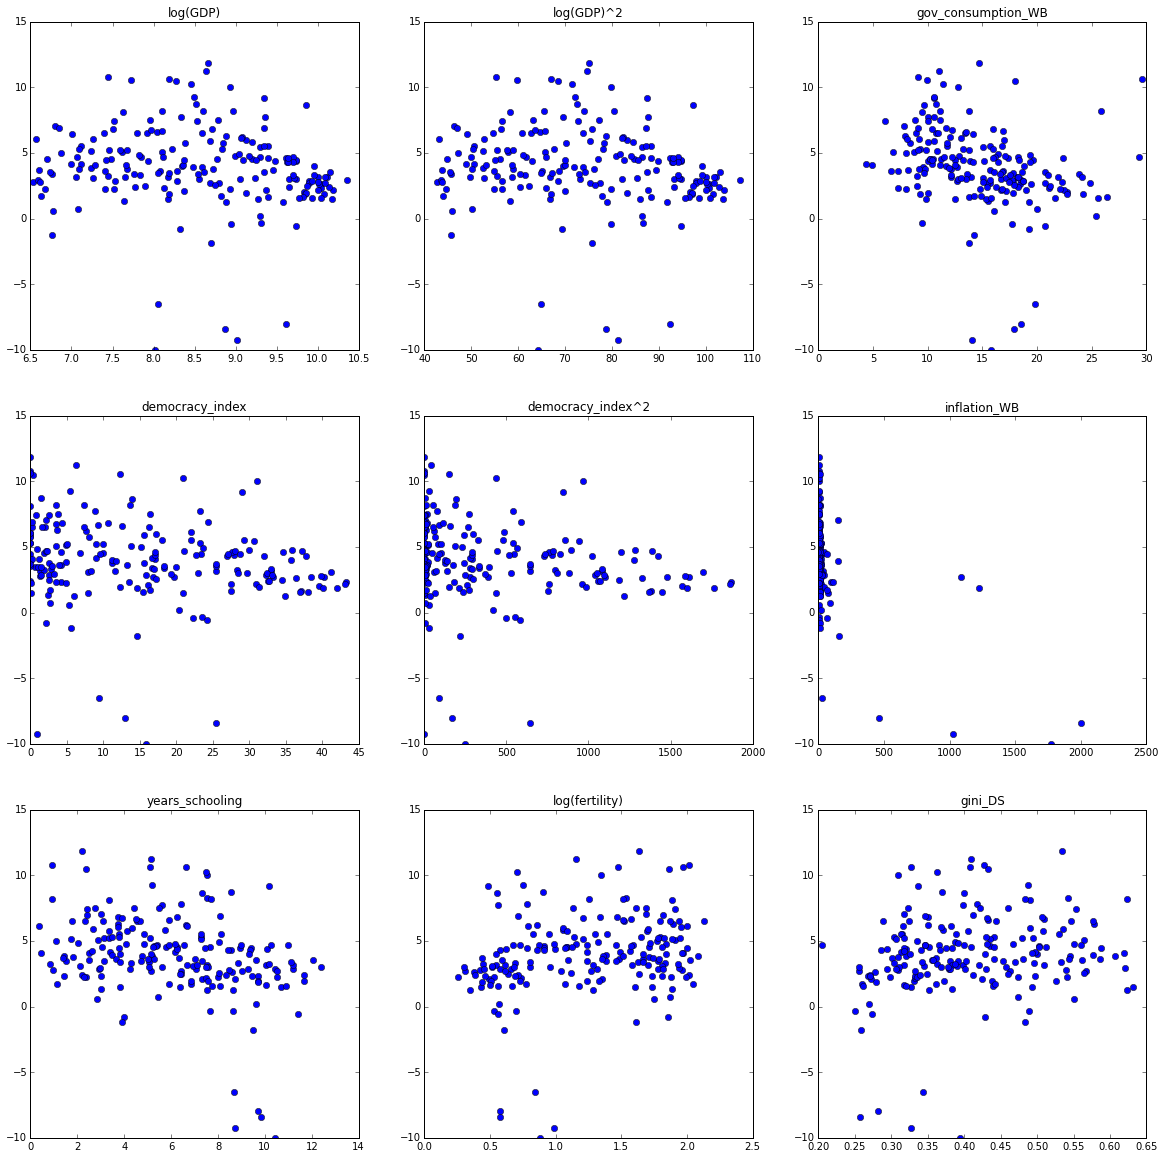

In [35]:
f, axarr = plt.subplots(3, 3, figsize=(20,20))
for n, var in enumerate(X_gini.keys()):
    i,j = n/3, n%3
    axarr[i, j].plot(X_gini[var], Y_gini, 'o')
    axarr[i, j].set_title(var)